In [8]:
PATH_TO_DATA_FROM_SCRIPT_3 = "9_1_full.csv"
PATH_TO_TRAINING_DATA = '~/NetSurfP-3.0_standalone/X_train_all_f2.csv'
PATH_TO_TRAINING_LABELS ='~/NetSurfP-3.0_standalone/Y_train_all_f2.csv'
MODEL_PATH = 'rf_model_no_disnetsurf.joblib'
SCALER_PATH = 'scaler_no_disnetsurf.joblib'
# Ensure to change paths to match your setup

In [9]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import sys
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [10]:
def _load_training_unscaled(train_data_path: str, train_labels_path: str):
    X_train_full = pd.read_csv(os.path.expanduser(train_data_path))
    if "ID" not in X_train_full.columns:
        raise ValueError("Training features file must include an 'ID' column.")
    X_train_full = X_train_full.set_index("ID")

    y_df = pd.read_csv(os.path.expanduser(train_labels_path), header=0, index_col=0)
    if y_df.empty:
        raise ValueError("Training labels file is empty or not formatted as expected.")
    # Align by ID
    common_ids = X_train_full.index.intersection(y_df.index)
    if len(common_ids) == 0:
        raise ValueError("No overlapping IDs between training features and labels.")
    X_train_full = X_train_full.loc[common_ids]
    y_vals = y_df.iloc[:, 0].loc[common_ids].astype(int).to_numpy()
    return X_train_full, y_vals

def plot_from_predictions_csv(
    uniprot_id: str,
    predictions_csv_path: str = "predictions_full_with_features.csv",
    train_data_path: str = "~/NetSurfP-3.0_standalone/X_train_all_f2.csv",
    train_labels_path: str = "~/NetSurfP-3.0_standalone/Y_train_all_f2.csv",
    bins: int = 10,
    max_cols: int = 5
):
    """
    Plot feature histograms using UN-SCALED training data and the sample's UN-SCALED values
    loaded from the predictions CSV. Also shows p(easy) and predicted label.

    Conventions:
      - 1 = "easy to cristal"
      - 0 = "hard to cristal"
    """
    pred_df = pd.read_csv(predictions_csv_path)
    if "ID" not in pred_df.columns:
        raise ValueError("Predictions CSV must contain an 'ID' column.")
    row = pred_df.loc[pred_df["ID"] == uniprot_id]
    if row.empty:
        raise ValueError(f"ID '{uniprot_id}' not found in {predictions_csv_path}")

    p_easy = float(row["p_easy"].iloc[0])
    p_hard = float(row["p_hard"].iloc[0])
    pred_label = str(row["pred_label"].iloc[0])
    y_pred = int(row["y_pred"].iloc[0])

    meta_cols = {"ID", "y_pred", "pred_label", "p_hard", "p_easy"}
    feature_cols = [c for c in pred_df.columns if c not in meta_cols]
    if not feature_cols:
        raise ValueError("No feature columns found in predictions CSV.")

    X_train_full, y_train = _load_training_unscaled(train_data_path, train_labels_path)
    missing = [c for c in feature_cols if c not in X_train_full.columns]
    if missing:
        raise ValueError(f"Training data missing columns present in CSV, e.g. {missing[:5]}")

    X_train = X_train_full[feature_cols].copy()
    train_df = X_train.copy()
    train_df["target"] = y_train.astype(int)

    sample_values = row[feature_cols].iloc[0]
    features = feature_cols
    num_features = len(features)
    num_cols = min(max_cols, max(1, num_features))
    num_rows = int(np.ceil(num_features / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, max(3.8, num_rows * 3.8)))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for i, feature in enumerate(features):
        ax = axes[i]
        class_0 = train_df[train_df['target'] == 0][feature]
        class_1 = train_df[train_df['target'] == 1][feature]
        all_values = pd.concat([class_0, class_1], axis=0)

        bin_edges = np.histogram_bin_edges(all_values.dropna().to_numpy(), bins=bins)
        ax.hist(class_0, bins=bin_edges, alpha=0.5, label='Class 0 (hard)', edgecolor='grey')
        ax.hist(class_1, bins=bin_edges, alpha=0.5, label='Class 1 (easy)', edgecolor='grey')

        sv = sample_values[feature]
        ax.axvline(sv, linestyle='--', linewidth=2)
        ymax = ax.get_ylim()[1]
        ax.text(sv, ymax * 0.92, f'{sv:.2f}', ha='center', va='top', fontsize=9)

        ax.set_title(feature)
        ax.set_xlabel('Value (unscaled)')
        ax.set_ylabel('Frequency')
        if i == 0:
            ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(
        f"ID: {uniprot_id} | Pred: {pred_label} (y_pred={y_pred}) | p(easy)={p_easy:.3f}, p(hard)={p_hard:.3f}",
        y=1.02
    )
    plt.tight_layout()
    plt.show()


# ==========================================
# Main function (augmented to save CSV etc.)
# ==========================================
def predict_and_visualize(new_data_path, model_path, scaler_path, train_data_path, train_labels_path):
    """
    Trains a model (if needed), makes predictions on new data, prints leaf composition,
    visualizes UN-SCALED feature distributions, and SAVES a CSV:
        [ID] + [UNSCALED feature columns] + y_pred + pred_label + p_hard + p_easy

    Conventions:
      - 1 = "easy to cristal"
      - 0 = "hard to cristal"
    """
    # Load UN-SCALED training data
    X_train_full = pd.read_csv(os.path.expanduser(train_data_path))
    X_train_full.set_index('ID', inplace=True)
    y_train = pd.read_csv(os.path.expanduser(train_labels_path), header=0, index_col=0).values.ravel().astype(int)

    # Ignore 'dis_netsurf' if present
    if 'dis_netsurf' in X_train_full.columns:
        X_train = X_train_full.drop(columns=['dis_netsurf'])
        print("Ignoring the 'dis_netsurf' column from the training data.")
    else:
        X_train = X_train_full

    expected_columns = X_train.columns

    # Train scaler + model on UN-SCALED X_train (scaling only for the model)
    print("\nTraining a new model without 'dis_netsurf' to ensure consistency.")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    joblib.dump(scaler, scaler_path)
    print(f"New scaler saved to {scaler_path}")

    model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, random_state=42)
    model.fit(X_train_scaled, y_train)
    joblib.dump(model, model_path)
    print(f"New model saved to {model_path}")

    loaded_model = model
    loaded_scaler = scaler
    print("\nUsing newly trained model and scaler for predictions.")

    # Load NEW data (UN-SCALED)
    new_data = pd.read_csv(new_data_path)
    new_data.set_index('ID', inplace=True)

    missing_cols = set(expected_columns) - set(new_data.columns)
    if missing_cols:
        print(f"Error: The new data is missing the following required columns: {list(missing_cols)}", file=sys.stderr)
        return

    # Align order with training columns (UN-SCALED)
    new_data_aligned = new_data[expected_columns]

    # Scale ONLY for the model’s prediction
    new_data_scaled = loaded_scaler.transform(new_data_aligned)

    # Predictions + probabilities
    predictions = loaded_model.predict(new_data_scaled).astype(int)

    # Ensure probabilities are ordered as [p(class 0), p(class 1)] -> [p(hard), p(easy)]
    raw_proba = loaded_model.predict_proba(new_data_scaled)  # columns follow loaded_model.classes_
    classes = getattr(loaded_model, "classes_", np.array([0, 1]))
    # Map columns to 0 and 1 explicitly
    try:
        idx0 = int(np.where(classes == 0)[0][0])
        idx1 = int(np.where(classes == 1)[0][0])
        probabilities = raw_proba[:, [idx0, idx1]]
    except Exception:
        probabilities = raw_proba  # fallback; RF usually already returns [0, 1]

    print("\nClass Predictions:", predictions)
    print("Prediction Probabilities [p(hard), p(easy)]:\n", np.round(probabilities, 4))


    label_map = {1: "easy to cristal", 0: "hard to cristal"}

    out_df = new_data_aligned.copy()                      # UN-SCALED features
    out_df["y_pred"] = predictions
    out_df["pred_label"] = out_df["y_pred"].map(label_map)
    out_df["p_hard"] = probabilities[:, 0]
    out_df["p_easy"] = probabilities[:, 1]

    # Move ID from index to column for convenience
    out_df = out_df.reset_index()  # index name is 'ID' already
    pred_csv_path = f"predictions_full_with_features_{new_data_path}"
    out_df.to_csv(pred_csv_path, index=False)
    print(f"\n Saved predictions CSV to: {pred_csv_path}")
    display(out_df.head())


    print("\n--- Leaf Purity Information ---")
    leaf_indices_new = loaded_model.apply(new_data_scaled)
    leaf_indices_train = loaded_model.apply(X_train_scaled)

    for i, sample_id in enumerate(new_data_aligned.index):
        total_class_1_in_leaves = 0
        total_samples_in_leaves = 0
        for tree_idx in range(loaded_model.n_estimators):
            leaf_id = leaf_indices_new[i, tree_idx]
            train_mask = (leaf_indices_train[:, tree_idx] == leaf_id)
            labels_in_leaf = y_train[train_mask]
            num_class_1 = int(np.sum(labels_in_leaf))
            total_in_leaf = int(len(labels_in_leaf))
            total_class_1_in_leaves += num_class_1
            total_samples_in_leaves += total_in_leaf

        print(f"\nSample '{sample_id}':")
        print(f"  - Across all trees, the sample landed in leaves containing a total of {total_class_1_in_leaves} training samples of class 1.")
        print(f"  - The total number of training samples in those leaves was {total_samples_in_leaves}.")
        if total_samples_in_leaves > 0:
            purity_percentage = (total_class_1_in_leaves / total_samples_in_leaves) * 100
            print(f"  - This corresponds to a class 1 purity of {purity_percentage:.2f}%.")
            print(f"  - (Note: The model's predicted probability for class 1 (easy) is {probabilities[i, 1]:.4f})")

    # ===========================
    # Visualization (UN-SCALED)
    # ===========================
    train_df = X_train.copy()
    train_df['target'] = y_train.astype(int)

    # Plot the FIRST sample from new data (UN-SCALED); for arbitrary IDs use plot_from_predictions_csv
    sample_to_plot = new_data_aligned.iloc[0]
    features = list(expected_columns)
    num_features = len(features)
    num_cols = 5
    num_rows = int(np.ceil(num_features / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        class_0 = train_df[train_df['target'] == 0][feature]
        class_1 = train_df[train_df['target'] == 1][feature]
        all_values = pd.concat([class_0, class_1])
        bins = np.histogram_bin_edges(all_values, bins=10)

        # UN-SCALED histograms
        ax.hist(class_0, bins=bins, alpha=0.5, label='Class 0 (hard)', color='blue', edgecolor='grey')
        ax.hist(class_1, bins=bins, alpha=0.5, label='Class 1 (easy)', color='orange', edgecolor='grey')

        sample_value = sample_to_plot[feature]
        ax.axvline(sample_value, color='red', linestyle='--', linewidth=2)
        ax.text(sample_value, ax.get_ylim()[1] * 0.9, f'{sample_value:.2f}', color='red', ha='center')

        ax.set_title(feature)
        ax.set_xlabel('Value (unscaled)')
        ax.set_ylabel('Frequency')
        if i == 0:
            ax.legend()

        # Optional density overlay (still UN-SCALED)
        ax2 = ax.twinx()
        all_values.plot(kind='density', ax=ax2, color='black')
        ax2.set_ylabel('Density')

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

    return {
        "predictions": predictions,
        "probabilities": probabilities,
        "predictions_csv": pred_csv_path,
        "features_used": list(expected_columns)
    }




Ignoring the 'dis_netsurf' column from the training data.

Training a new model without 'dis_netsurf' to ensure consistency.
New scaler saved to scaler_no_disnetsurf.joblib
New model saved to rf_model_no_disnetsurf.joblib

Using newly trained model and scaler for predictions.

Class Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Prediction Probabilities [p(hard), p(easy)]:
 [[0.72  0.28 ]
 [0.625 0.375]
 [0.63  0.37 ]
 [0.63  0.37 ]
 [0.645 0.355]
 [0.675 0.325]
 [0.72  0.28 ]
 [0.7   0.3  ]
 [0.67  0.33 ]
 [0.585 0.415]
 [0.555 0.445]
 [0.675 0.325]
 [0.615 0.385]
 [0.61  0.39 ]
 [0.7   0.3  ]
 [0.655 0.345]
 [0.64  0.36 ]
 [0.665 0.335]
 [0.605 0.395]
 [0.73  0.27 ]
 [0.77  0.23 ]
 [0.645 0.355]
 [0.615 0.385]
 [0.535 0.465]
 [0.615 0.385]
 [0.605 0.395]
 [0.64  0.36 ]
 [0.63  0.37 ]
 [0.59  0.41 ]
 [0.55  0.45 ]
 [0.59  0.41 ]
 [0.635 0.365]
 [0.59  0.41 ]
 [0.59  0.41 ]
 [0.59  0.41 ]
 [0.59  0.41 ]
 [0.59  0.41 ]
 [0.5

,ID,Length,Gravy,Instability_index,Isoelectric_point,C_count,M_count,W_count,Y_count,F_count,...,count of surface R,count of surface S,count of surface T,count of surface V,count of surface W,count of surface Y,y_pred,pred_label,p_hard,p_easy
0,A5KZL0,394,-0.55,47.36,8.11,6,4,5,9,18,...,0.072711,0.089760,0.066494,0.038437,0.006326,0.016248,0,hard to cristal,0.720,0.280
1,A0A432XPD4,445,-0.56,36.40,5.51,4,6,8,6,28,...,0.062495,0.096393,0.066183,0.035557,0.008188,0.007822,0,hard to cristal,0.625,0.375
2,A0A7Y4EY46,452,-0.52,43.19,6.33,6,9,6,11,19,...,0.064144,0.074063,0.058974,0.058269,0.005854,0.013134,0,hard to cristal,0.630,0.370
3,A0A7Y3Z4P4,457,-0.51,36.07,8.09,6,6,6,13,19,...,0.065351,0.077845,0.062118,0.051034,0.004983,0.016431,0,hard to cristal,0.630,0.370
4,A0A368NMU0,476,-0.57,40.93,8.42,9,8,6,14,19,...,0.074844,0.071246,0.059290,0.033905,0.005500,0.017730,0,hard to cristal,0.645,0.355



--- Leaf Purity Information ---

Sample 'A5KZL0':
  - Across all trees, the sample landed in leaves containing a total of 875 training samples of class 1.
  - The total number of training samples in those leaves was 6148.
  - This corresponds to a class 1 purity of 14.23%.
  - (Note: The model's predicted probability for class 1 (easy) is 0.2800)

Sample 'A0A432XPD4':
  - Across all trees, the sample landed in leaves containing a total of 1070 training samples of class 1.
  - The total number of training samples in those leaves was 5646.
  - This corresponds to a class 1 purity of 18.95%.
  - (Note: The model's predicted probability for class 1 (easy) is 0.3750)

Sample 'A0A7Y4EY46':
  - Across all trees, the sample landed in leaves containing a total of 1073 training samples of class 1.
  - The total number of training samples in those leaves was 4625.
  - This corresponds to a class 1 purity of 23.20%.
  - (Note: The model's predicted probability for class 1 (easy) is 0.3700)

Sampl

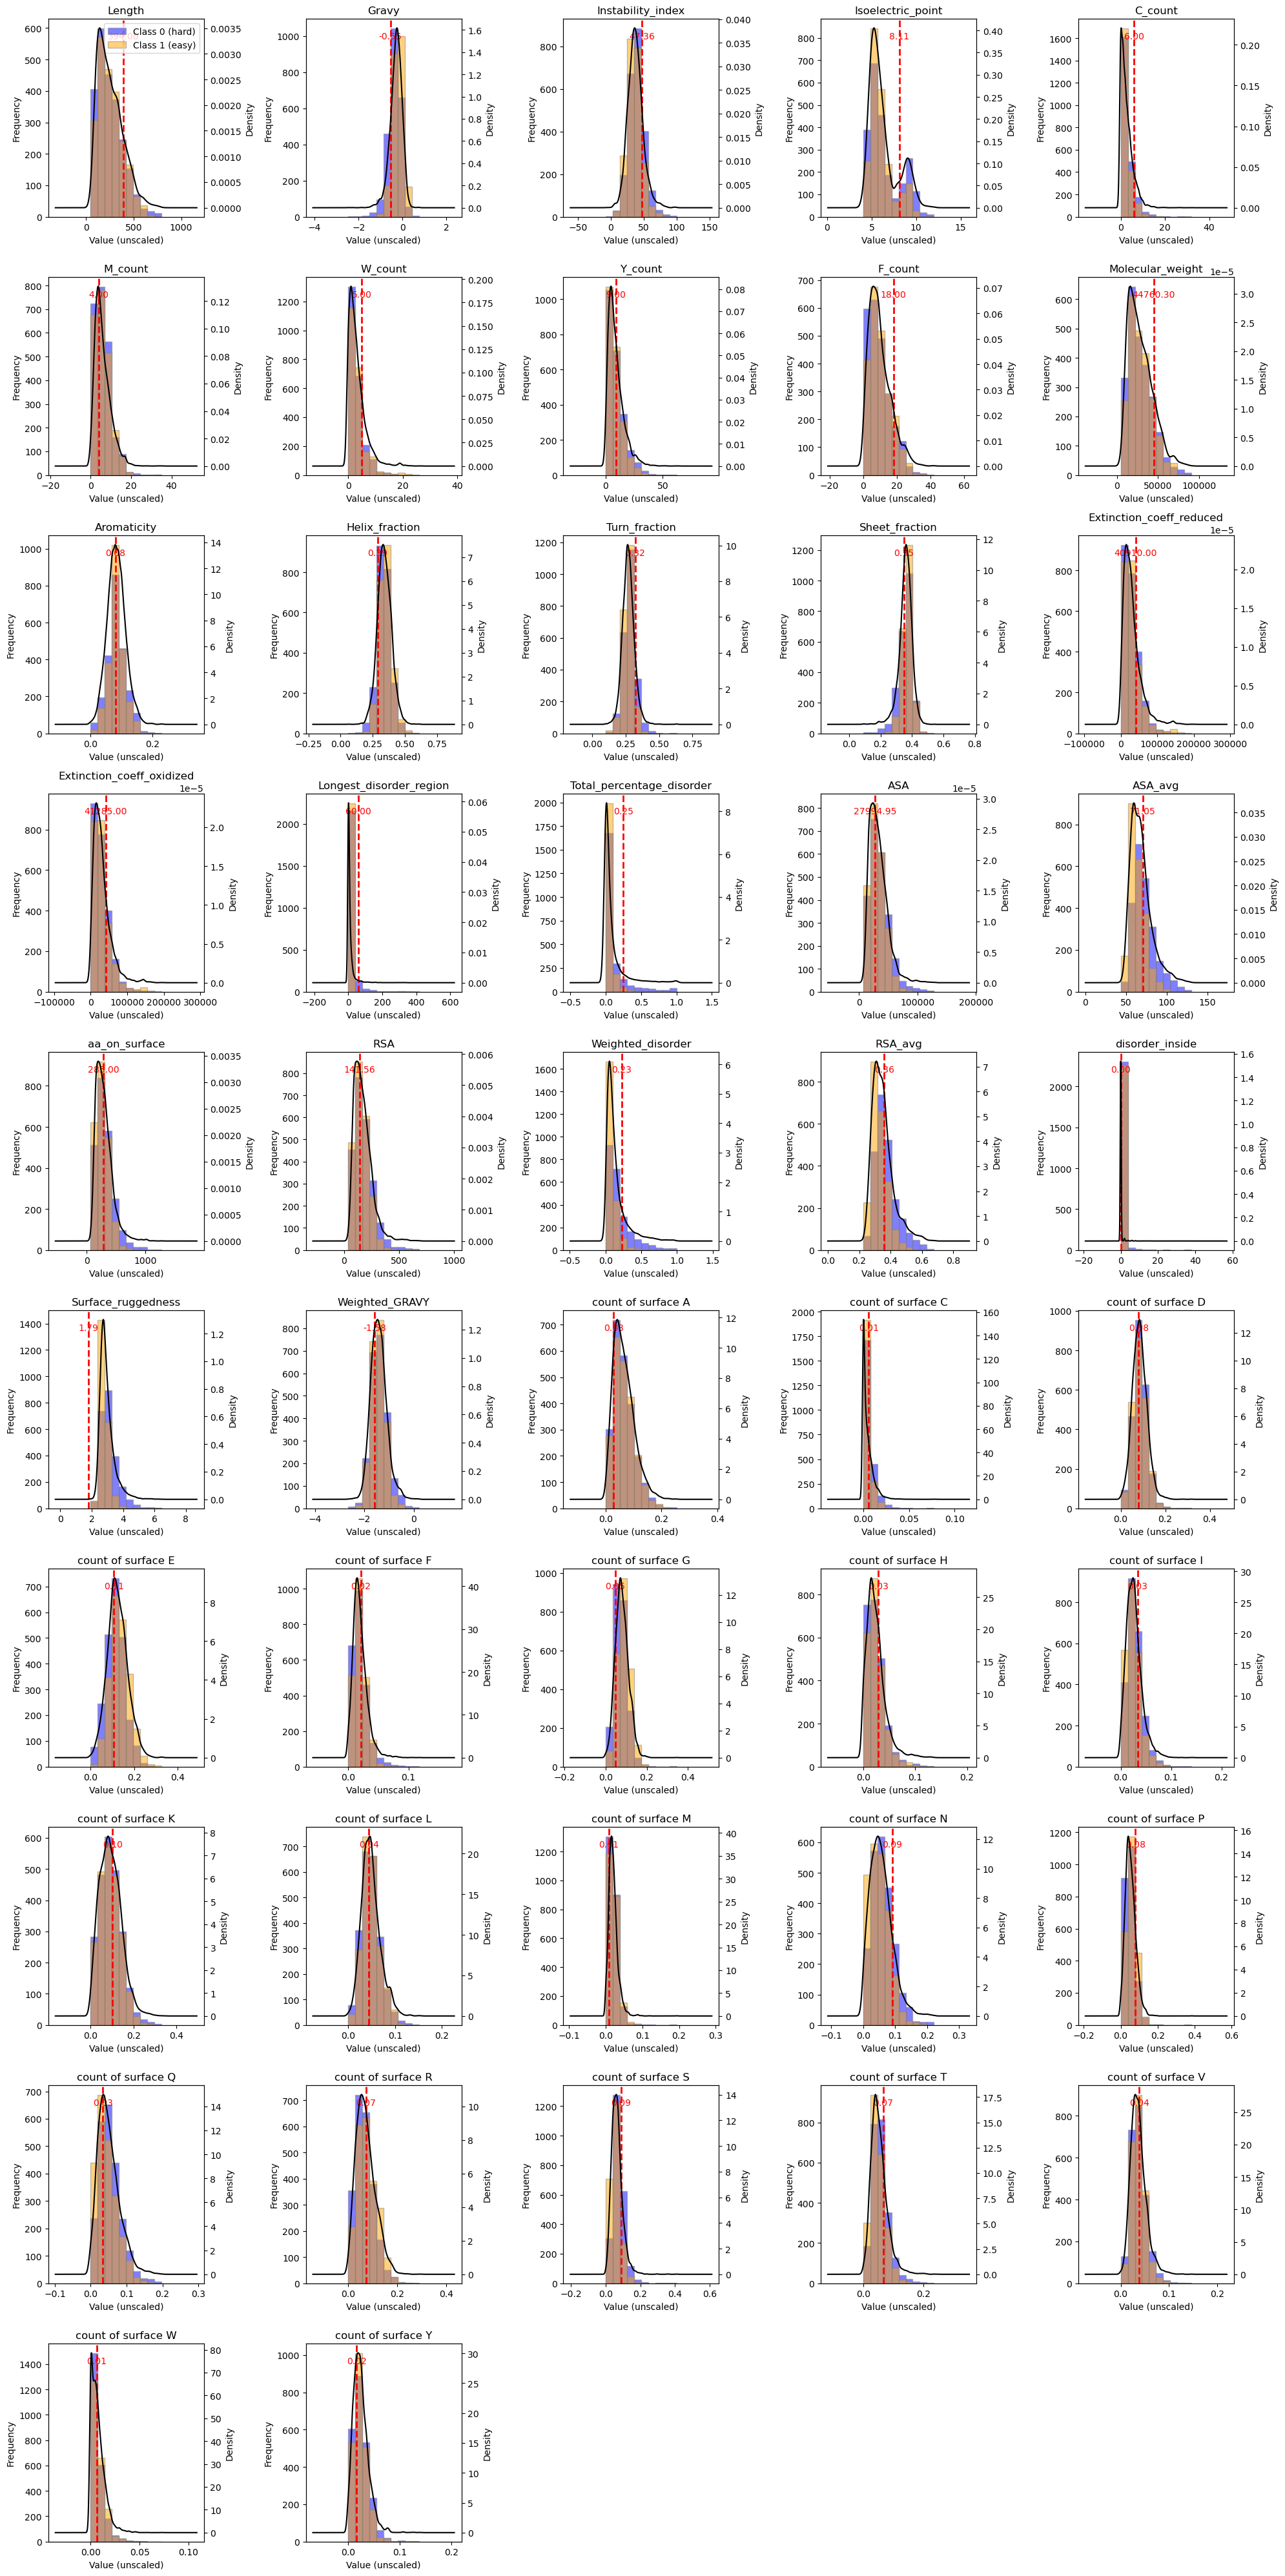

In [11]:
res = predict_and_visualize(
    new_data_path=PATH_TO_DATA_FROM_SCRIPT_3,
    model_path=MODEL_PATH,
    scaler_path=SCALER_PATH,
    train_data_path=PATH_TO_TRAINING_DATA ,
    train_labels_path=PATH_TO_TRAINING_LABELS 
)



In [13]:
def plot_top5_easy_from_csv(
    predictions_csv_path,
    train_data_path,
    train_labels_path,
    bins: int = 20,
    max_cols: int = 5,
    features_subset: list | None = None
):
    """
    Plots per-feature histograms (UNSCALED) and overlays vertical lines for the
    top-5 samples with the highest p_easy (class 1). Lines use distinct colors.

    Parameters
    ----------
    predictions_csv_path : str
        Path to CSV created by your predict/save step.
    train_data_path : str
        Path to unscaled training features CSV (has ID column).
    train_labels_path : str
        Path to training labels CSV (index=ID).
    bins : int
        Number of histogram bins.
    max_cols : int
        Max subplot columns.
    features_subset : list[str] | None
        If provided, only plot these features (must be present in CSV).
    """
    pred_df = pd.read_csv(predictions_csv_path)
    required_cols = {"ID", "p_easy", "p_hard", "y_pred", "pred_label"}
    if not required_cols.issubset(set(pred_df.columns)):
        missing = required_cols - set(pred_df.columns)
        raise ValueError(f"Predictions CSV missing columns: {missing}")

    meta_cols = {"ID", "y_pred", "pred_label", "p_hard", "p_easy"}
    feature_cols = [c for c in pred_df.columns if c not in meta_cols]
    if features_subset is not None:
        missing_fs = [c for c in features_subset if c not in feature_cols]
        if missing_fs:
            raise ValueError(f"features_subset includes columns not in CSV: {missing_fs}")
        feature_cols = list(features_subset)

    # --- Pick top-5 by p_easy ---
    pred_sorted = pred_df.sort_values("p_easy", ascending=False)
    topK = min(5, len(pred_sorted))
    if topK == 0:
        raise ValueError("No rows in predictions CSV.")
    top_df = pred_sorted.head(topK).copy()
    top_ids = top_df["ID"].tolist()
    top_probs = top_df["p_easy"].tolist()

    # --- Load unscaled training data + labels ---
    X_train_full, y_train = _load_training_unscaled(train_data_path, train_labels_path)

    # Ensure training data has all needed feature columns
    missing_in_train = [c for c in feature_cols if c not in X_train_full.columns]
    if missing_in_train:
        raise ValueError(f"Training data missing columns present in CSV: {missing_in_train[:10]}")

    # Build plotting frame
    X_train = X_train_full[feature_cols].copy()
    train_df = X_train.copy()
    train_df["target"] = y_train.astype(int)

    # Colors for the 5 lines
    color_bank = plt.cm.tab10.colors  # distinct categorical palette
    colors = [color_bank[i % len(color_bank)] for i in range(topK)]
    id_to_color = {uid: colors[i] for i, uid in enumerate(top_ids)}

    # --- Subplot grid ---
    features = feature_cols
    num_features = len(features)
    num_cols = min(max_cols, max(1, num_features))
    num_rows = int(np.ceil(num_features / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, max(3.8, num_rows * 3.8)))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    # --- Plot per feature ---
    for i, feature in enumerate(features):
        ax = axes[i]
        class_0 = train_df.loc[train_df['target'] == 0, feature]
        class_1 = train_df.loc[train_df['target'] == 1, feature]
        all_values = pd.concat([class_0, class_1], axis=0)

        bin_edges = np.histogram_bin_edges(all_values.dropna().to_numpy(), bins=bins)

        # Histograms (UNSCALED)
        ax.hist(class_0, bins=bin_edges, alpha=0.5, label='Class 0 (failure)', color='blue', edgecolor='grey')
        ax.hist(class_1, bins=bin_edges, alpha=0.5, label='Class 1 (success)', color='orange', edgecolor='grey')

        for uid, col in id_to_color.items():
            sample_value = pd.to_numeric(pred_df.loc[pred_df["ID"] == uid, feature].iloc[0], errors="coerce")
            ax.axvline(sample_value, color=col, linestyle='--', linewidth=2, alpha=0.95)

        ax.set_title(feature)
        ax.set_xlabel('Value (unscaled)')
        ax.set_ylabel('Frequency')

        if i == 0:
            class_handles = [
                Patch(facecolor='blue', edgecolor='grey', alpha=0.5, label='Class 0 (hard)'),
                Patch(facecolor='orange', edgecolor='grey', alpha=0.5, label='Class 1 (easy)')
            ]
            sample_handles = [
                Line2D([0], [0], color=id_to_color[uid], linestyle='--', linewidth=2,
                       label=f"{uid} (p={p:.2f})")
                for uid, p in zip(top_ids, top_probs)
            ]
            ax.legend(handles=class_handles + sample_handles, fontsize=8, loc='upper right', framealpha=0.9)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    title_ids = ", ".join([f"{uid}:{p:.2f}" for uid, p in zip(top_ids, top_probs)])
    print(title_ids)
    plt.suptitle(f"Top {topK} by p(success) — IDs: {title_ids}", y=1.02)
    plt.tight_layout()
    plt.show()


A0A8B5ZKG8:0.47, A0A317ZRR1:0.45, A0A1M6PZG6:0.45, A0A1S2CE08:0.41, A0A177Y386:0.41


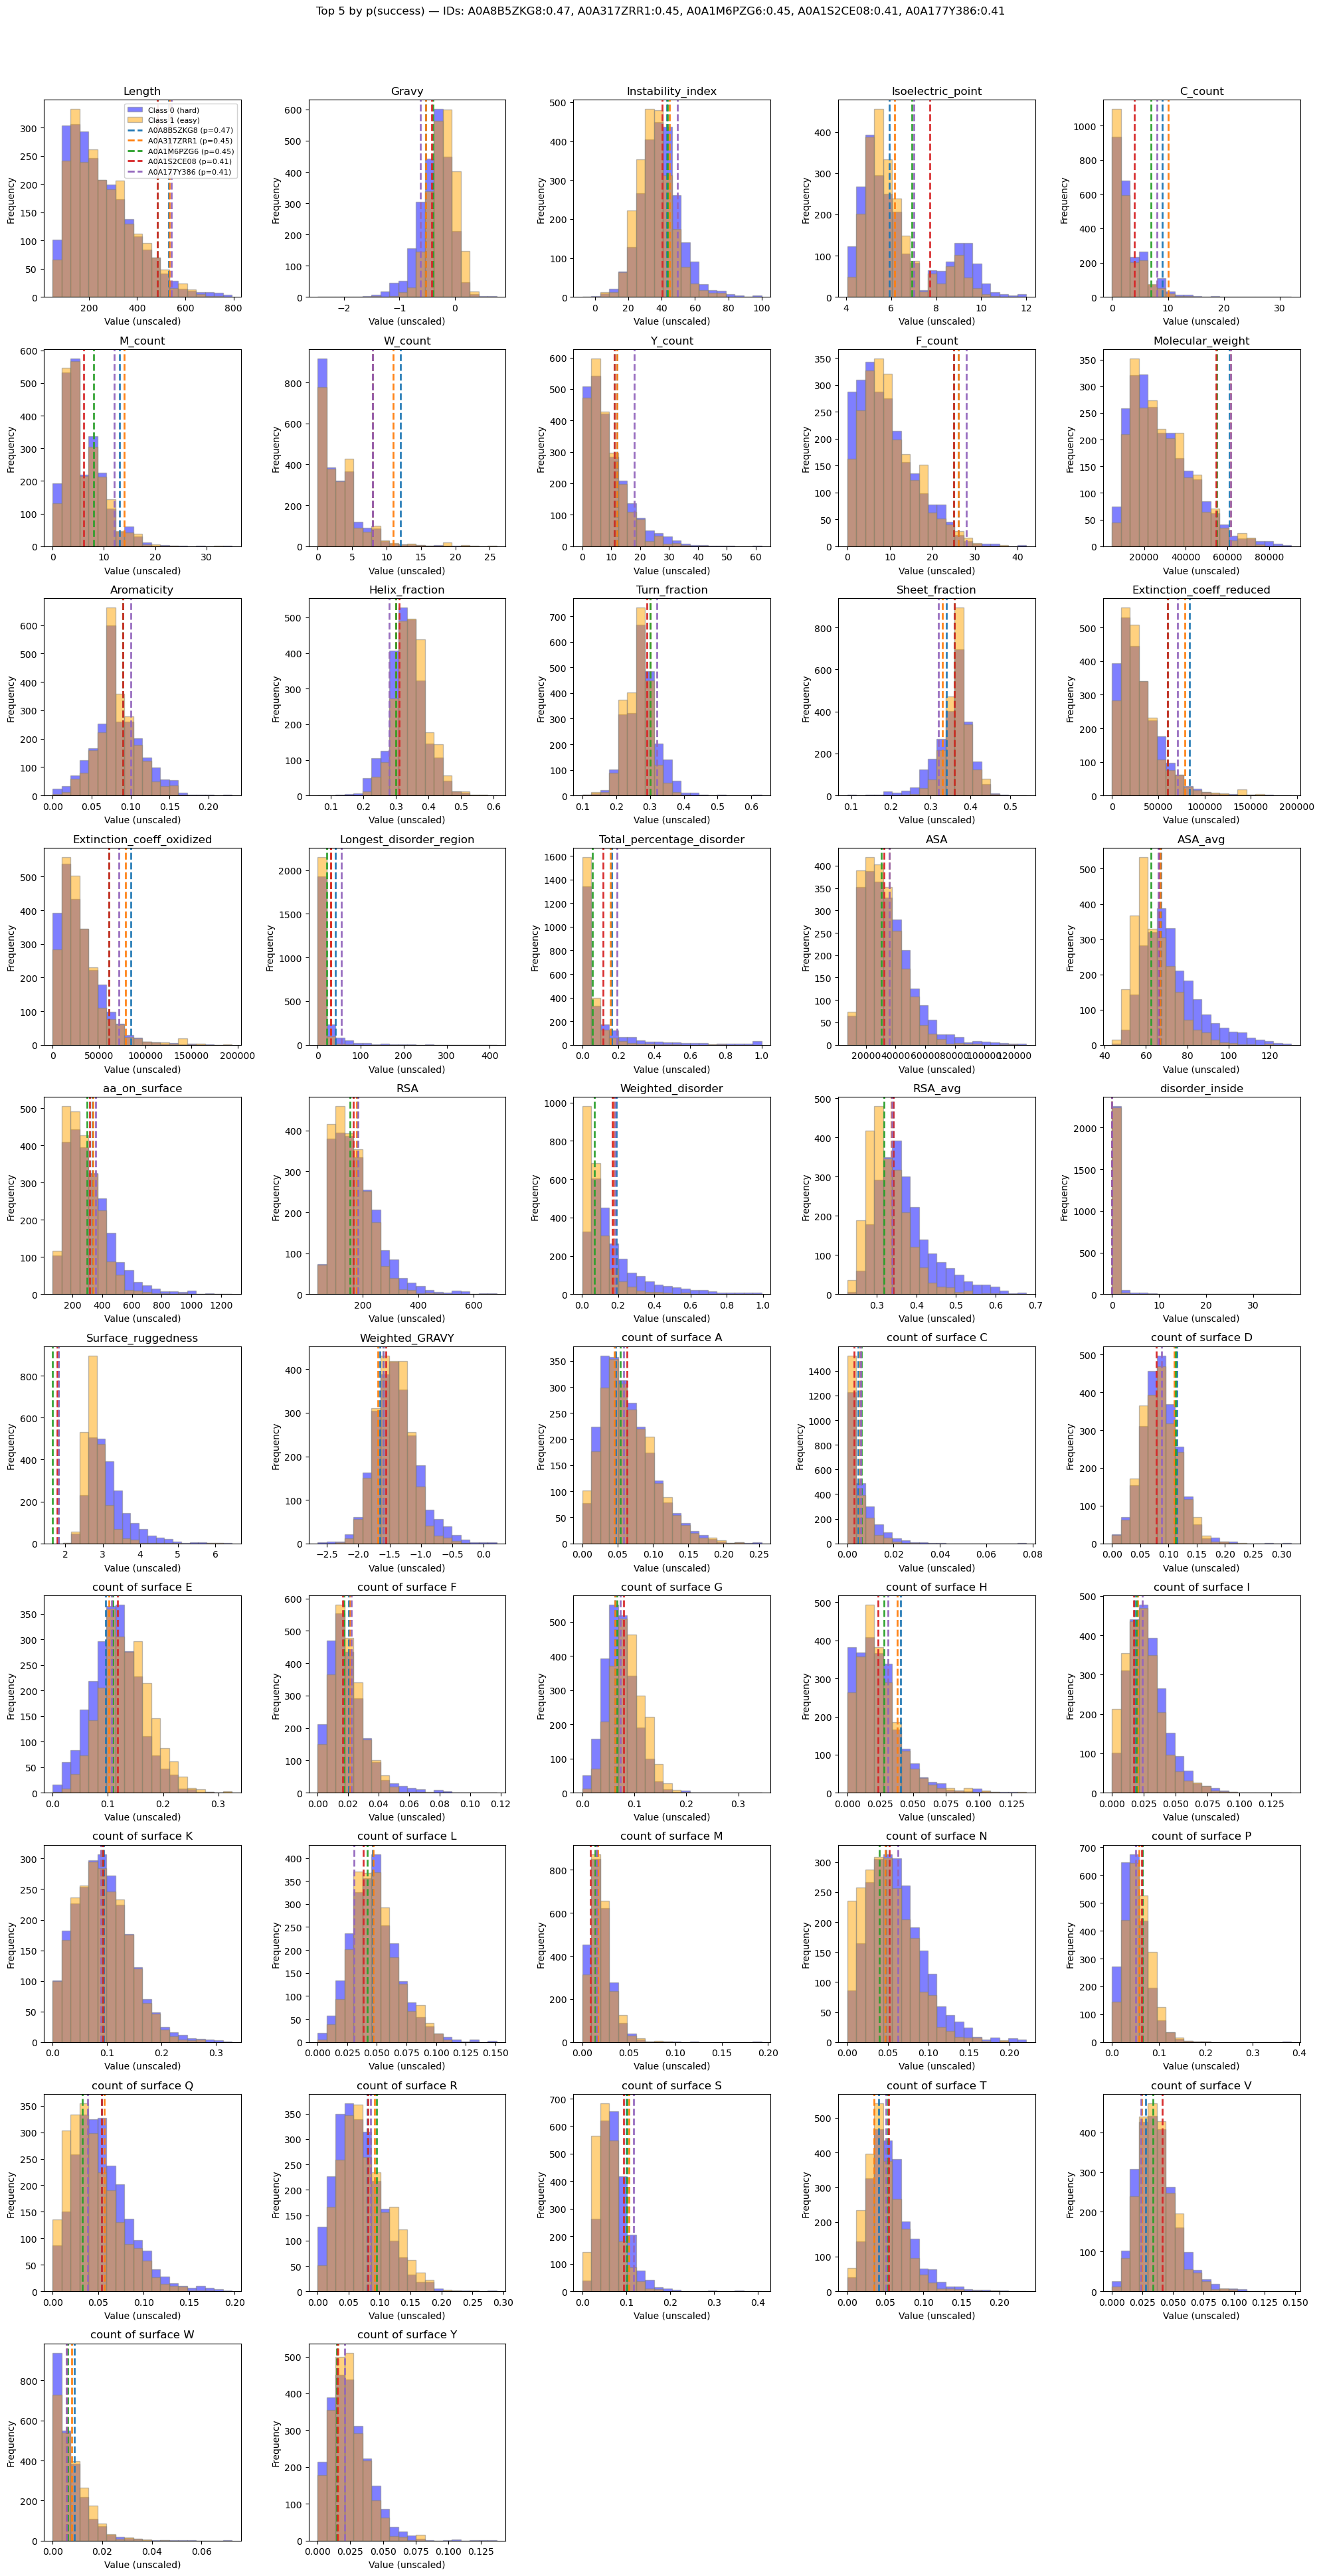

In [14]:
plot_top5_easy_from_csv(    predictions_csv_path=f"predictions_full_with_features_{PATH_TO_DATA_FROM_SCRIPT_3}",
    train_data_path = PATH_TO_TRAINING_DATA,
    train_labels_path=PATH_TO_TRAINING_LABELS)

A0A849UEA0:0.52, A0A2G2N6R4:0.51, A0A3L8BK81:0.49, A3DAQ4:0.49, A0A7I8HZC7:0.49


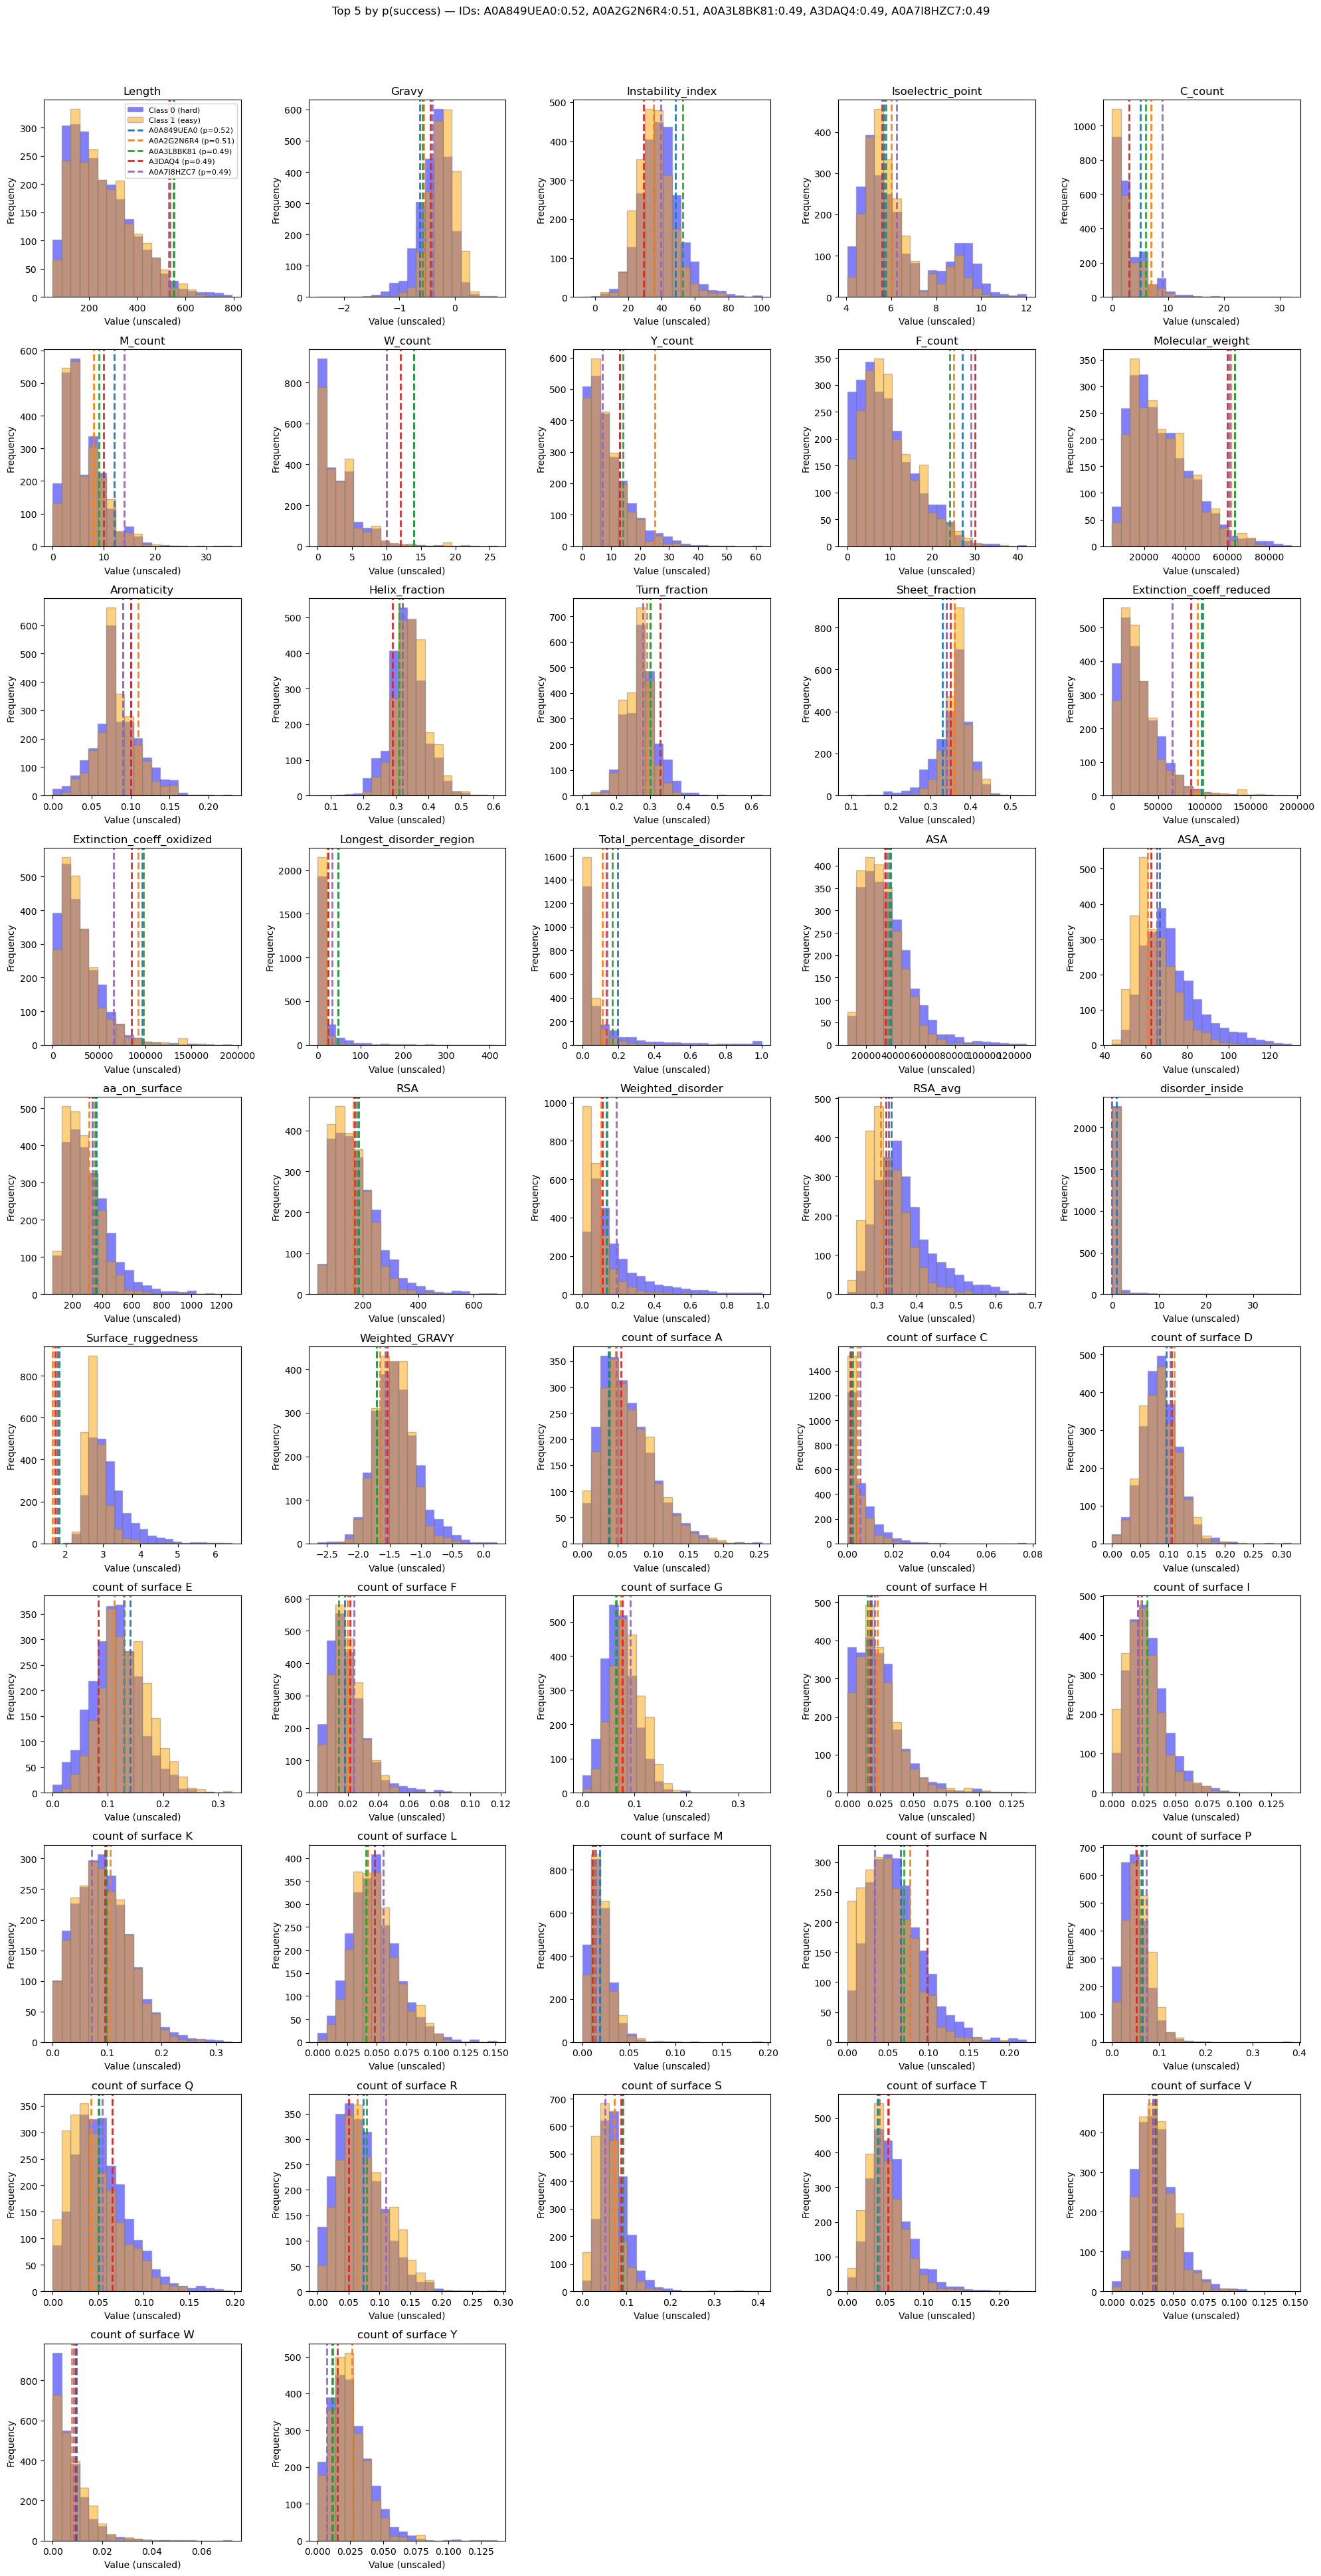

In [6]:
"""plot_top5_easy_from_csv(    predictions_csv_path="predictions_full_with_features_7_1_full.csv",
    train_data_path="~/NetSurfP-3.0_standalone/X_train_all_f2.csv",
    train_labels_path="~/NetSurfP-3.0_standalone/Y_train_all_f2.csv")"""